# Project 1 - Store Sales Time Series Forecasting

## Penjelasan Template
Template ini ditujukan untuk memberi gambaran tentang alur kerja yang diharapkan dalam menyelesaikan project 1 - Store Sales Time Series Forecasting. Template ini juga akan memberikan contoh-contoh kode yang bisa digunakan untuk membantu menyelesaikan project ini. Template ini tidak mengikat, artinya kamu bebas untuk menyelesaikan project ini dengan alur kerja yang kamu rasa paling tepat. Silahkan lakukan modifikasi pada template ini sesuai dengan kebutuhan kamu.

Semangat mengerjakan projectnya!

## Objective
- Memahami data yang digunakan, bagaimana melihat data, melakukan visualisasi hingga memahami karakteristik time series data.
- Melakukan process data, seperti cleaning, transformasi, hingga feature engineering.
- Melakukan pemodelan menggunakan ARIMA dan LSTM.
- Melakukan evaluasi model yang telah dibuat.
- Menarik kesimpulan dari hasil analisis yang telah dilakukan.

## Terms
- `ARIMA` : Autoregressive Integrated Moving Average, model statistik yang digunakan dalam analisis data time series.
- `LSTM` : Long Short Term Memory, model neural network yang digunakan dalam analisis data time series.
- `Time Series` : Data yang terurut berdasarkan waktu.
- `Forecasting` : Proses memprediksi nilai di masa depan berdasarkan data masa lalu.


## Penjelasan singkat tentang data

you will predict sales for the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models.

https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data

# Import Library

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import TimeseriesGenerator

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

# Prepare the Data

Pada bagian ini, kamu akan mempersiapkan data yang akan digunakan. Proses ini meliputi:
1. Load data
2. Cek data
3. Cleaning data


In [4]:
from google.colab import drive
import os
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/ML Bootcamp/Project 1'

Mounted at /content/drive
/content/drive/MyDrive/ML Bootcamp/Project 1


In [5]:
df_train = pd.read_csv('store5.csv')
df_train

,id,date,store_nbr,family,sales,onpromotion,dcoilwtico
0,1452,2013-01-01,5,AUTOMOTIVE,0.000,0,NaN
1,1453,2013-01-01,5,BABY CARE,0.000,0,NaN
2,1454,2013-01-01,5,BEAUTY,0.000,0,NaN
3,1455,2013-01-01,5,BEVERAGES,0.000,0,NaN
4,1456,2013-01-01,5,BOOKS,0.000,0,NaN
...,...,...,...,...,...,...,...
55567,3000586,2017-08-15,5,POULTRY,241.011,1,47.57
55568,3000587,2017-08-15,5,PREPARED FOODS,52.121,0,47.57
55569,3000588,2017-08-15,5,PRODUCE,1357.823,4,47.57
55570,3000589,2017-08-15,5,SCHOOL AND OFFICE SUPPLIES,0.000,0,47.57


In [6]:
df_train.isnull().sum()

id                 0
date               0
store_nbr          0
family             0
sales              0
onpromotion        0
dcoilwtico     17193
dtype: int64

Data dcoilwitco (Daily oil price) merupakan data yang berisi harga minyak mentah harian. Data ini akan digunakan untuk mengekstrak fitur baru yang akan digunakan dalam model. Namun data ini tidak memiliki tanggal yang lengkap, sehingga perlu dilakukan interpolasi untuk mengisi tanggal yang kosong.

In [7]:
df_train['family'].value_counts()

AUTOMOTIVE                    1684
HOME APPLIANCES               1684
SCHOOL AND OFFICE SUPPLIES    1684
PRODUCE                       1684
PREPARED FOODS                1684
POULTRY                       1684
PLAYERS AND ELECTRONICS       1684
PET SUPPLIES                  1684
PERSONAL CARE                 1684
MEATS                         1684
MAGAZINES                     1684
LIQUOR,WINE,BEER              1684
LINGERIE                      1684
LAWN AND GARDEN               1684
LADIESWEAR                    1684
HOME CARE                     1684
HOME AND KITCHEN II           1684
BABY CARE                     1684
HOME AND KITCHEN I            1684
HARDWARE                      1684
GROCERY II                    1684
GROCERY I                     1684
FROZEN FOODS                  1684
EGGS                          1684
DELI                          1684
DAIRY                         1684
CLEANING                      1684
CELEBRATION                   1684
BREAD/BAKERY        

Semua data memiliki jumlah yang sama

In [8]:
df_train.drop(['id', 'store_nbr'], axis=1, inplace=True)
df_copy = df_train.copy()
df_train['date'] = pd.to_datetime(df_train['date'])
df_train = df_train.set_index('date')
df_train

,family,sales,onpromotion,dcoilwtico
date,,,,
2013-01-01,AUTOMOTIVE,0.000,0,NaN
2013-01-01,BABY CARE,0.000,0,NaN
2013-01-01,BEAUTY,0.000,0,NaN
2013-01-01,BEVERAGES,0.000,0,NaN
2013-01-01,BOOKS,0.000,0,NaN
...,...,...,...,...
2017-08-15,POULTRY,241.011,1,47.57
2017-08-15,PREPARED FOODS,52.121,0,47.57
2017-08-15,PRODUCE,1357.823,4,47.57


# EDA (Exploratory Data Analysis)

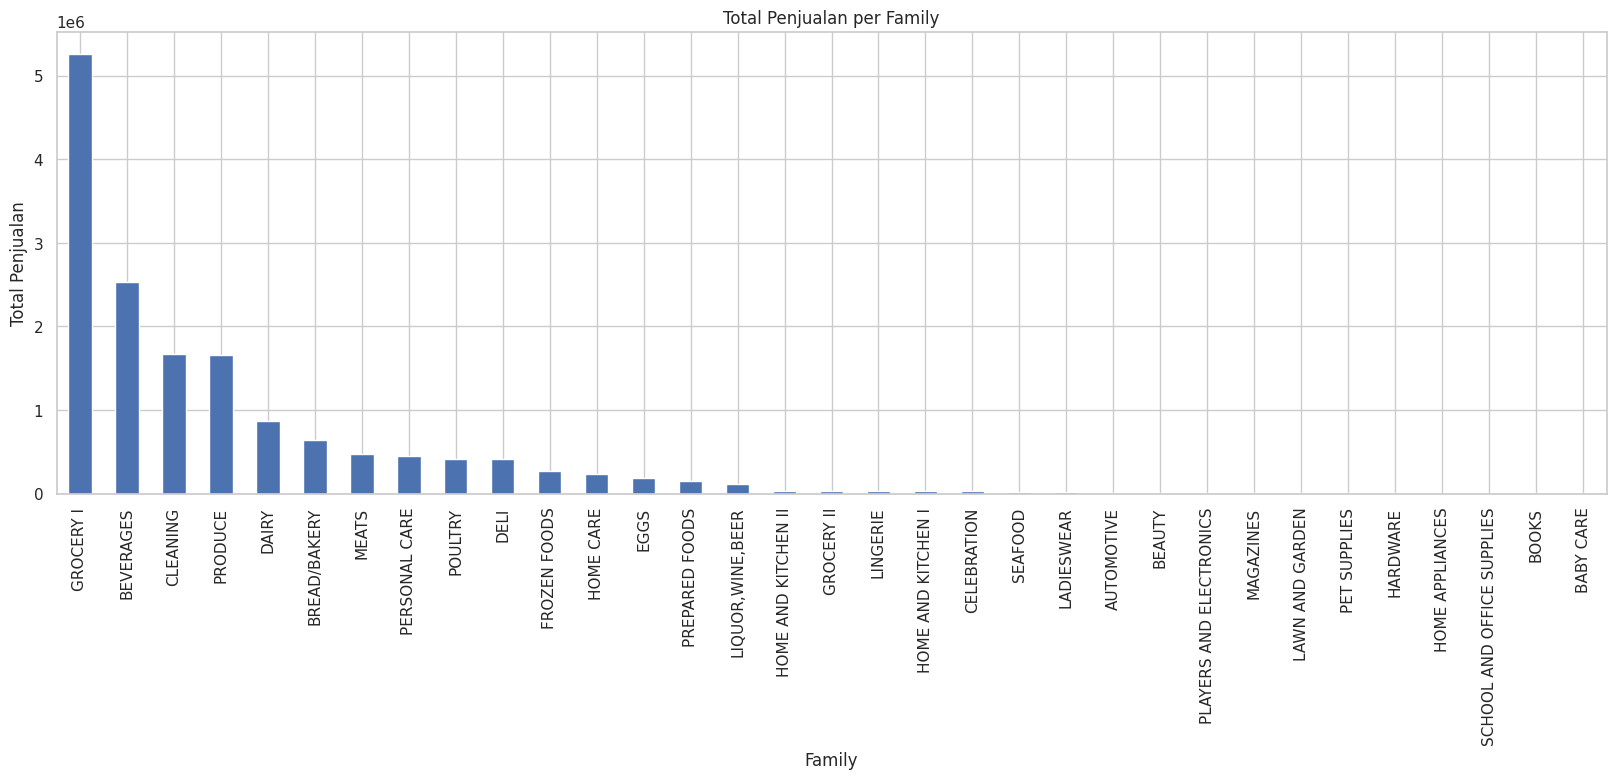

In [9]:
plt.figure(figsize=(20,6))
sns.set(style='whitegrid')

df_train.groupby('family')['sales'].sum().sort_values(ascending=False).plot(kind='bar')
plt.title('Total Penjualan per Family')
plt.xlabel('Family')
plt.ylabel('Total Penjualan')
plt.show()

In [10]:
df_train.groupby('family')['sales'].sum().sort_values(ascending=False)

family
GROCERY I                     5.262682e+06
BEVERAGES                     2.533831e+06
CLEANING                      1.667748e+06
PRODUCE                       1.653582e+06
DAIRY                         8.712830e+05
BREAD/BAKERY                  6.428546e+05
MEATS                         4.771044e+05
PERSONAL CARE                 4.501660e+05
POULTRY                       4.196304e+05
DELI                          4.152710e+05
FROZEN FOODS                  2.696692e+05
HOME CARE                     2.392830e+05
EGGS                          1.908510e+05
PREPARED FOODS                1.479911e+05
LIQUOR,WINE,BEER              1.104140e+05
HOME AND KITCHEN II           3.723800e+04
GROCERY II                    3.324100e+04
LINGERIE                      3.156100e+04
HOME AND KITCHEN I            3.010700e+04
CELEBRATION                   2.617600e+04
SEAFOOD                       2.235899e+04
LADIESWEAR                    1.481300e+04
AUTOMOTIVE                    9.194000e+03
BEAU

<Figure size 2000x600 with 0 Axes>

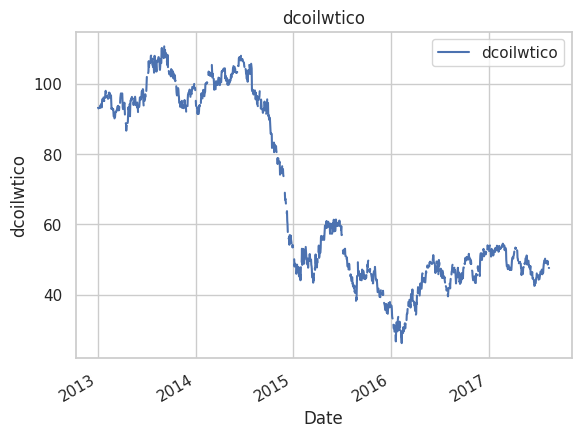

In [12]:
dcoilwtico = df_train['family']=='PRODUCE'
dcoilwtico = df_train[dcoilwtico]
dcoilwtico = dcoilwtico[['dcoilwtico']]

plt.figure(figsize=(20,6))
sns.set(style='whitegrid')
dcoilwtico.plot()
plt.title('dcoilwtico')
plt.xlabel('Date')
plt.ylabel('dcoilwtico')
plt.show()

Terdapat beberapa data yang hilang, kamu dapat melakukan imputasi data yang hilang dengan menggunakan teknik yang tepat.

## EDA per family

Pada part ini, kamu bisa mencoba melakukan EDA pada family tertentu. Hal ini bisa membantu kamu dalam memahami data lebih dalam.

In [13]:
produce = df_train['family']=='PRODUCE'
produce = df_train[produce]
produce

,family,sales,onpromotion,dcoilwtico
date,,,,
2013-01-01,PRODUCE,0.0000,0,NaN
2013-01-02,PRODUCE,0.0000,0,93.14
2013-01-03,PRODUCE,0.0000,0,92.97
2013-01-04,PRODUCE,0.0000,0,93.12
2013-01-05,PRODUCE,0.0000,0,NaN
...,...,...,...,...
2017-08-11,PRODUCE,1470.0920,6,48.81
2017-08-12,PRODUCE,1466.7090,2,NaN
2017-08-13,PRODUCE,1487.2210,3,NaN


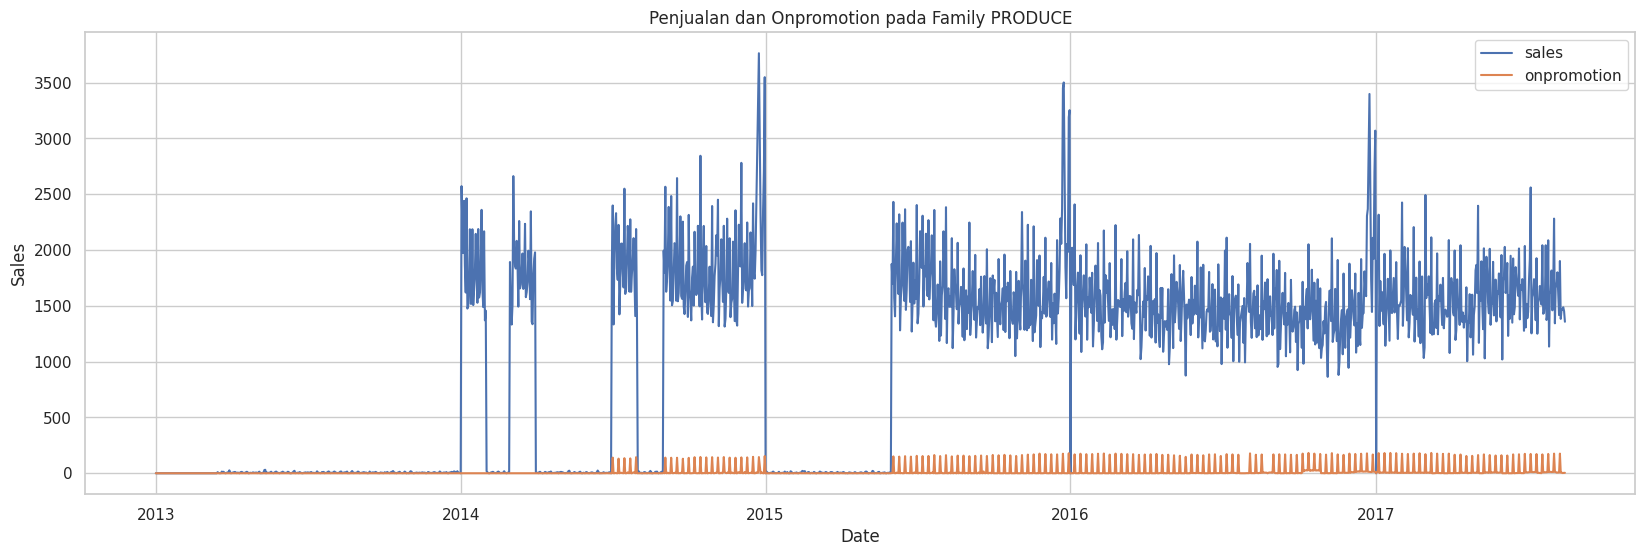

In [15]:
plt.figure(figsize=(20,6))
sns.set(style='whitegrid')
sns.lineplot(data=produce, x='date', y='sales', label='sales')
sns.lineplot(data=produce, x='date', y='onpromotion', label='onpromotion')
plt.title('Penjualan dan Onpromotion pada Family PRODUCE')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

<Axes: xlabel='date'>

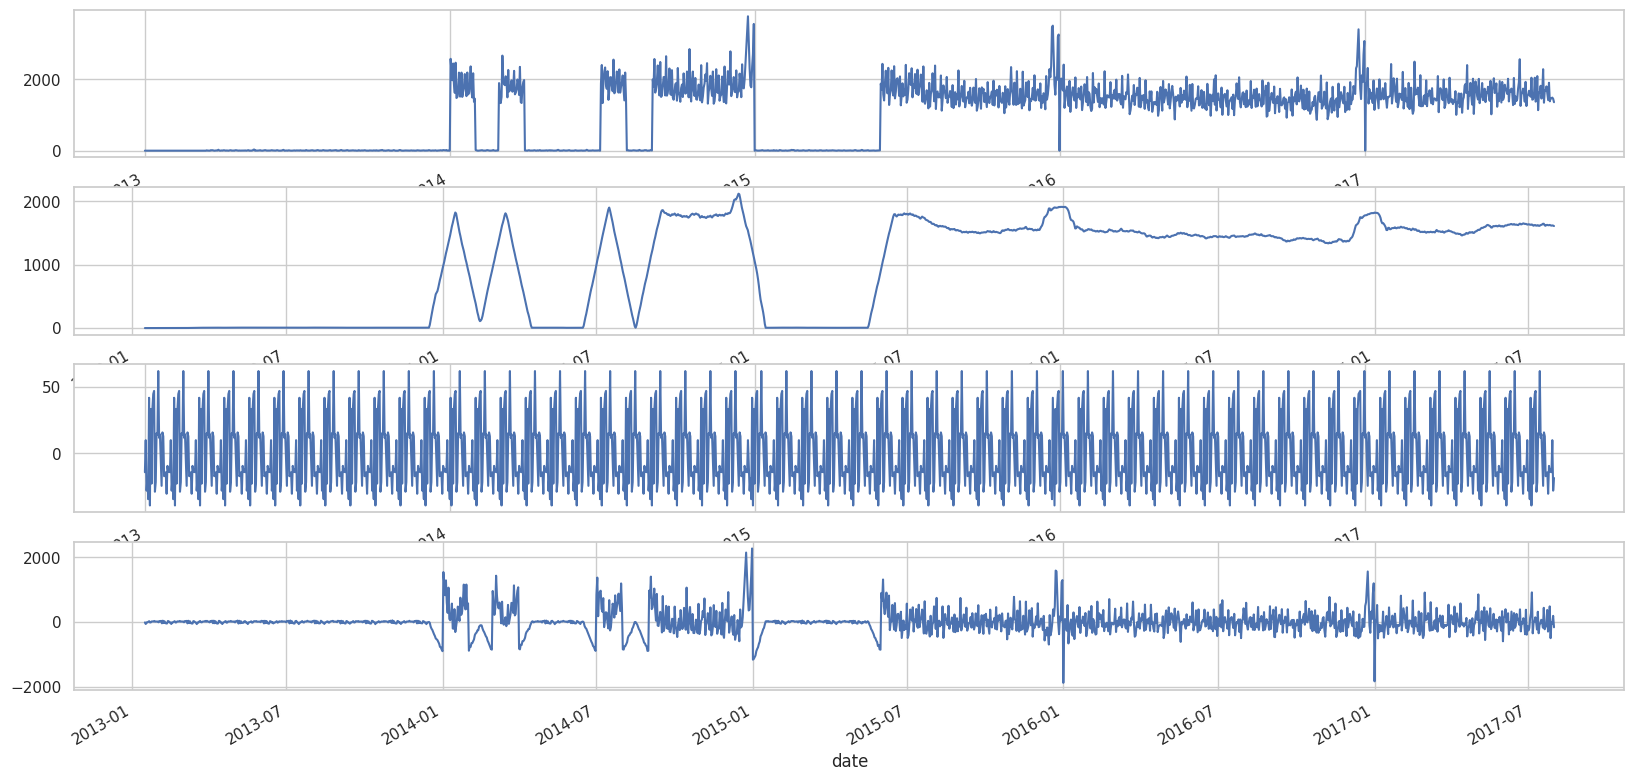

In [17]:
plot_decompose = seasonal_decompose(produce['sales'], model='additive', period=30)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 10))
plot_decompose.observed.plot(ax=ax1)
plot_decompose.trend.plot(ax=ax2)
plot_decompose.seasonal.plot(ax=ax3)
plot_decompose.resid.plot(ax=ax4)

In [19]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(produce['sales'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.801625
p-value: 0.002891


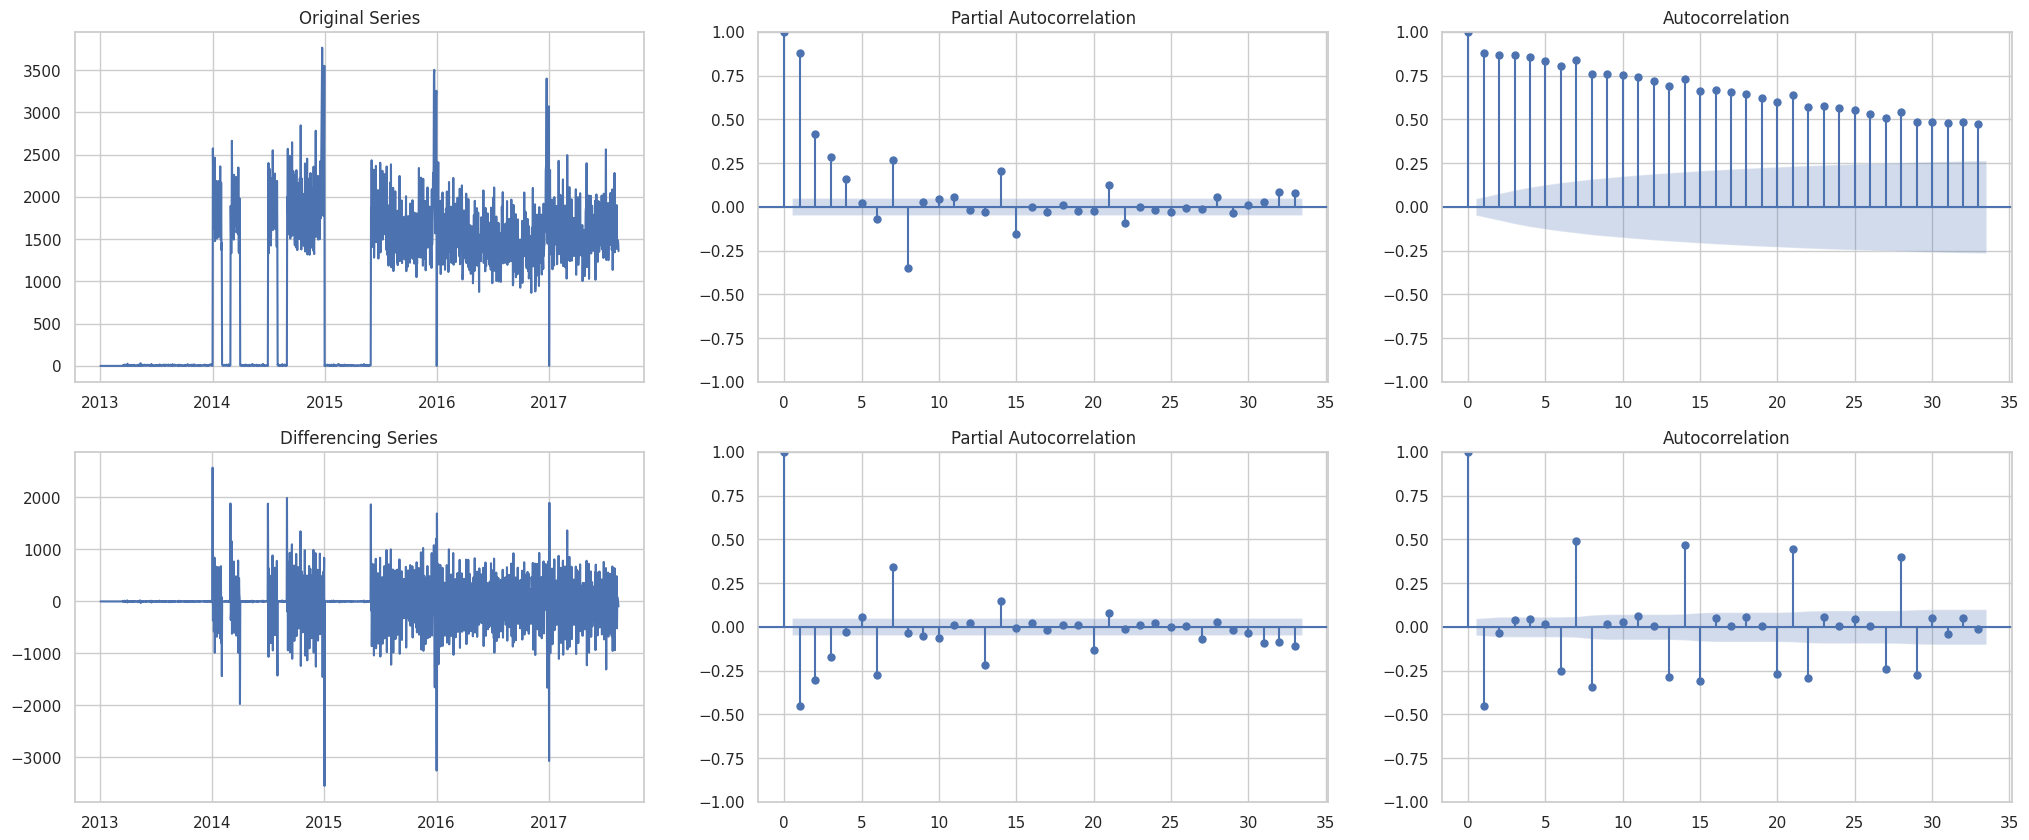

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2, 3, figsize=(25, 10))

ax[0, 0].set_title('Original Series')
ax[0, 0].plot(produce['sales'])
ax[0, 1] = plot_pacf(produce['sales'], ax=ax[0, 1])
ax[0, 2] = plot_acf(produce['sales'], ax=ax[0, 2])

ax[1, 0].set_title('Differencing Series')
ax[1, 0].plot(produce['sales'].diff().dropna())
ax[1, 1] = plot_pacf(produce['sales'].diff().dropna(), ax=ax[1, 1])
ax[1, 2] = plot_acf(produce['sales'].diff().dropna(), ax=ax[1, 2])

plt.show()

# Feature Engineering

Kamu boleh melakukan feature engineering sesuai dengan pemahaman dan eksplorasi kamu terhadap data. Abaikan feature engineering yang tidak dibutuhkan. <br>
Beberapa ide feature engineering yang bisa dilakukan adalah:
- Menambahkan fitur tanggal
- Memberikan imputasi pada data yang hilang
- Menambah fitur baru yang dihasilkan dari data (mean, median, dll)
- Memisahkan antara data latihan dan data validasi
- Dan masih banyak lainnya

In [21]:
produce = produce.copy()
produce.loc[:, 'year'] = produce.index.year
produce.loc[:, 'month'] = produce.index.month
produce.loc[:, 'day'] = produce.index.day
produce.loc[:, 'dayofweek'] = produce.index.dayofweek
produce

,family,sales,onpromotion,dcoilwtico,year,month,day,dayofweek
date,,,,,,,,
2013-01-01,PRODUCE,0.0000,0,NaN,2013,1,1,1
2013-01-02,PRODUCE,0.0000,0,93.14,2013,1,2,2
2013-01-03,PRODUCE,0.0000,0,92.97,2013,1,3,3
2013-01-04,PRODUCE,0.0000,0,93.12,2013,1,4,4
2013-01-05,PRODUCE,0.0000,0,NaN,2013,1,5,5
...,...,...,...,...,...,...,...,...
2017-08-11,PRODUCE,1470.0920,6,48.81,2017,8,11,4
2017-08-12,PRODUCE,1466.7090,2,NaN,2017,8,12,5
2017-08-13,PRODUCE,1487.2210,3,NaN,2017,8,13,6


In [22]:
produce['dcoilwtico'] = produce['dcoilwtico'].fillna(method='ffill')
produce

,family,sales,onpromotion,dcoilwtico,year,month,day,dayofweek
date,,,,,,,,
2013-01-01,PRODUCE,0.0000,0,NaN,2013,1,1,1
2013-01-02,PRODUCE,0.0000,0,93.14,2013,1,2,2
2013-01-03,PRODUCE,0.0000,0,92.97,2013,1,3,3
2013-01-04,PRODUCE,0.0000,0,93.12,2013,1,4,4
2013-01-05,PRODUCE,0.0000,0,93.12,2013,1,5,5
...,...,...,...,...,...,...,...,...
2017-08-11,PRODUCE,1470.0920,6,48.81,2017,8,11,4
2017-08-12,PRODUCE,1466.7090,2,48.81,2017,8,12,5
2017-08-13,PRODUCE,1487.2210,3,48.81,2017,8,13,6


In [23]:
produce.isnull().sum()

family         0
sales          0
onpromotion    0
dcoilwtico     1
year           0
month          0
day            0
dayofweek      0
dtype: int64

In [24]:
produce['dcoilwtico'] = produce['dcoilwtico'].fillna(method='bfill')
produce

,family,sales,onpromotion,dcoilwtico,year,month,day,dayofweek
date,,,,,,,,
2013-01-01,PRODUCE,0.0000,0,93.14,2013,1,1,1
2013-01-02,PRODUCE,0.0000,0,93.14,2013,1,2,2
2013-01-03,PRODUCE,0.0000,0,92.97,2013,1,3,3
2013-01-04,PRODUCE,0.0000,0,93.12,2013,1,4,4
2013-01-05,PRODUCE,0.0000,0,93.12,2013,1,5,5
...,...,...,...,...,...,...,...,...
2017-08-11,PRODUCE,1470.0920,6,48.81,2017,8,11,4
2017-08-12,PRODUCE,1466.7090,2,48.81,2017,8,12,5
2017-08-13,PRODUCE,1487.2210,3,48.81,2017,8,13,6


In [25]:
produce['sales_mean_7'] = produce['sales'].rolling(window=7).mean()
produce['sales_mean_30'] = produce['sales'].rolling(window=30).mean()
produce

,family,sales,onpromotion,dcoilwtico,year,month,day,dayofweek,sales_mean_7,sales_mean_30
date,,,,,,,,,,
2013-01-01,PRODUCE,0.0000,0,93.14,2013,1,1,1,NaN,NaN
2013-01-02,PRODUCE,0.0000,0,93.14,2013,1,2,2,NaN,NaN
2013-01-03,PRODUCE,0.0000,0,92.97,2013,1,3,3,NaN,NaN
2013-01-04,PRODUCE,0.0000,0,93.12,2013,1,4,4,NaN,NaN
2013-01-05,PRODUCE,0.0000,0,93.12,2013,1,5,5,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2017-08-11,PRODUCE,1470.0920,6,48.81,2017,8,11,4,1608.699286,1612.735270
2017-08-12,PRODUCE,1466.7090,2,48.81,2017,8,12,5,1578.760714,1619.938637
2017-08-13,PRODUCE,1487.2210,3,48.81,2017,8,13,6,1534.003286,1618.483403


In [26]:
train = produce[:-30]
test = produce[-30:]
print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: (1654, 10)
Test shape: (30, 10)


# Modeling

## Model ARIMA

### SARIMAX (p,d,q)
Tentukan nilai ARIMA berdasarkan pengamatanmu, lalu lakukan pemodelan menggunakan ARIMA. <br>
Kamu bebas menentukan apakah menggunakan ARIMA, SARIMA, atau ARIMA yang lain. <br>
Pastikan untuk mengevaluasi model yang telah dibuat.

In [27]:
model_sarimax = ARIMA(train['sales'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 7), exog=train['onpromotion'])
model_sarimax_fit = model_sarimax.fit()
print(model_sarimax_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                    
Dep. Variable:                           sales   No. Observations:                 1654
Model:             ARIMA(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood              -11616.382
Date:                         Mon, 18 Mar 2024   AIC                          23246.764
Time:                                 14:52:39   BIC                          23284.641
Sample:                                      0   HQIC                         23260.806
                                        - 1654                                         
Covariance Type:                           opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         859.2404    462.384      1.858      0.063     -47.016    1765.497
onpromotion     4.6539      0.117     39.913      0.000 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


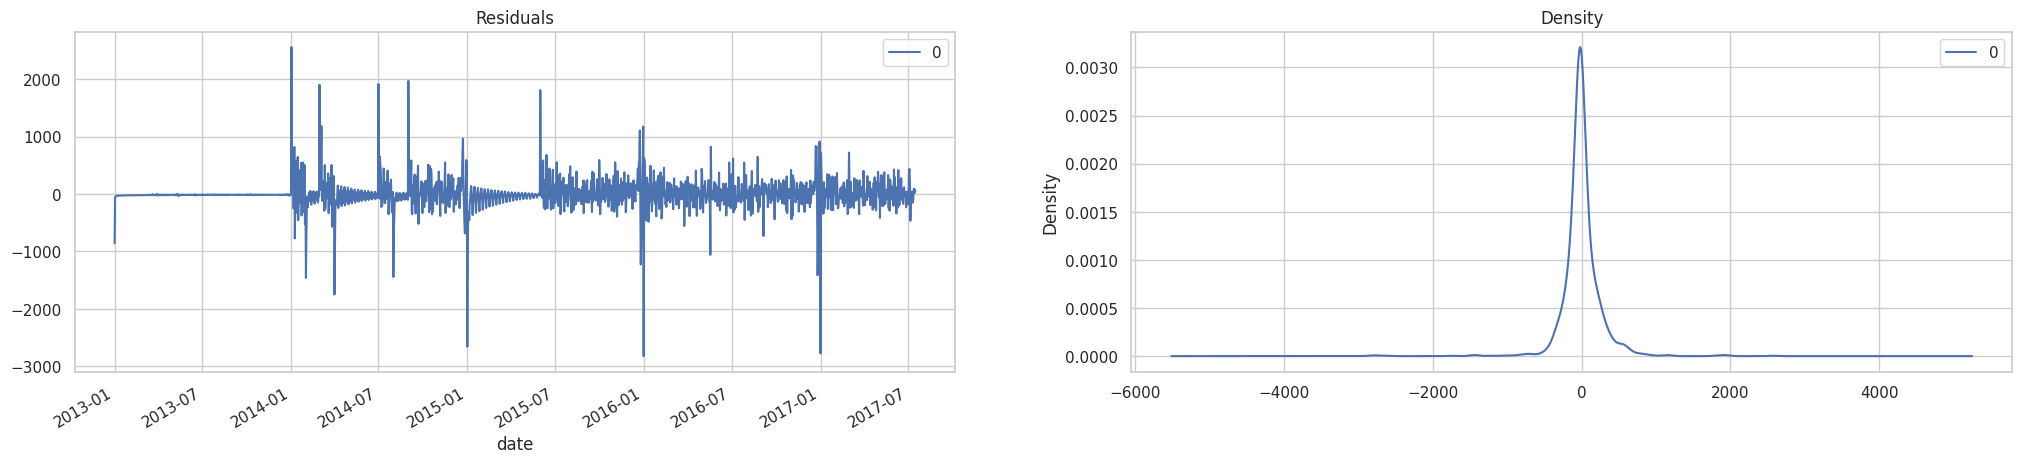

In [28]:
residuals = pd.DataFrame(model_sarimax_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(25,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


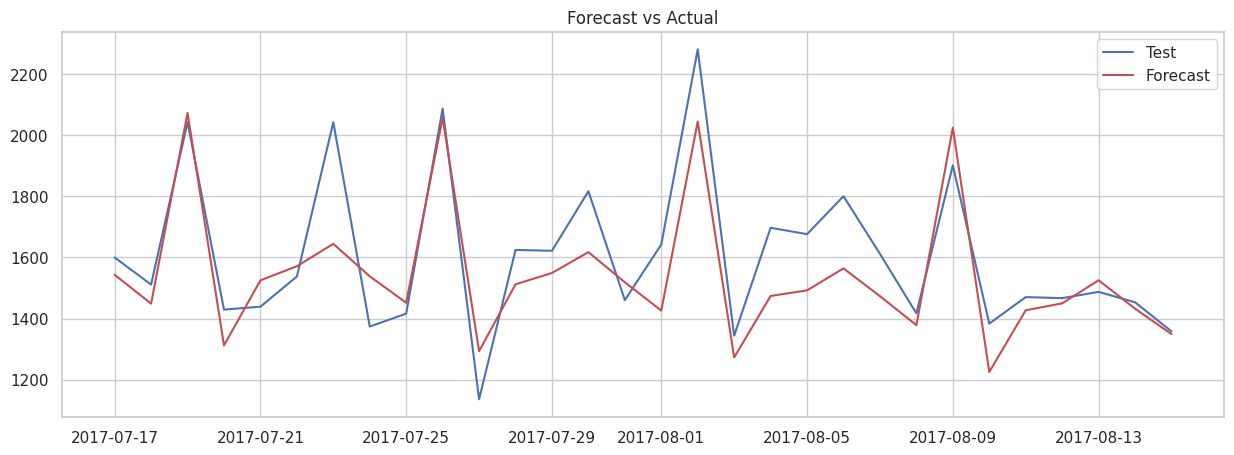

In [29]:
exog_forecast = test['onpromotion']
forecast = model_sarimax_fit.predict(start=len(train), end=len(train)+len(test)-1, exog=exog_forecast, typ='levels')
forecast.index = test.index

plt.figure(figsize=(15,5))
plt.title('Forecast vs Actual')
plt.plot(test['sales'], label='Test')
plt.plot(forecast, label='Forecast', color='r')
plt.legend()

In [30]:
forecastSARIMAX = pd.DataFrame({'test': test['sales'], 'forecast': forecast})
forecastSARIMAX

,test,forecast
date,,
2017-07-17,1599.7670,1543.226057
2017-07-18,1511.1580,1448.694885
2017-07-19,2043.2310,2073.533688
2017-07-20,1429.2040,1311.821569
2017-07-21,1438.7240,1524.972270
2017-07-22,1537.5890,1571.277577
2017-07-23,2042.9550,1644.696773
2017-07-24,1373.6490,1538.187615
2017-07-25,1416.1060,1451.681394


### Model SARIMA


In [31]:
model_sarima = ARIMA(train['sales'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 7))
model_sarima_fit = model_sarima.fit()
print(model_sarima_fit.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                    
Dep. Variable:                           sales   No. Observations:                 1654
Model:             ARIMA(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood              -11777.984
Date:                         Mon, 18 Mar 2024   AIC                          23567.968
Time:                                 14:52:57   BIC                          23600.434
Sample:                                      0   HQIC                         23580.004
                                        - 1654                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        970.6433    368.009      2.638      0.008     249.359    1691.927
ar.L1          0.9380      0.010     98.532      0.000     

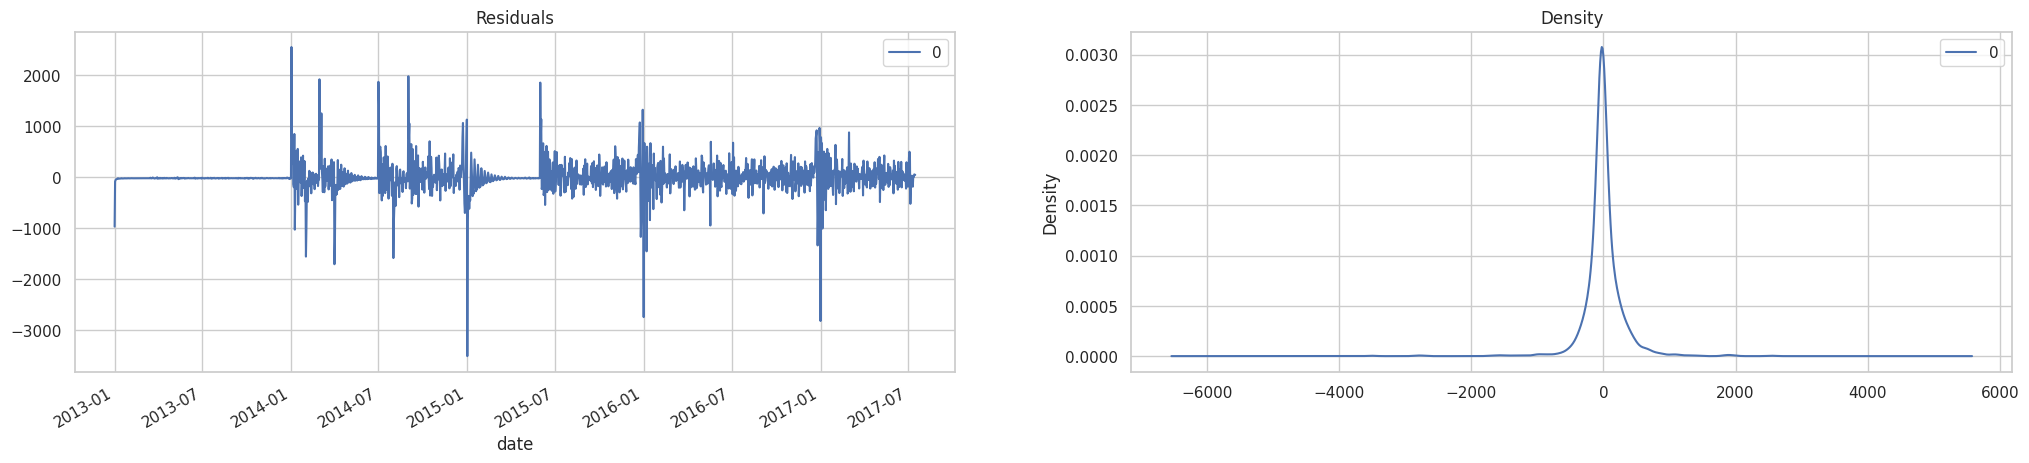

In [32]:
residuals = pd.DataFrame(model_sarima_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(25,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


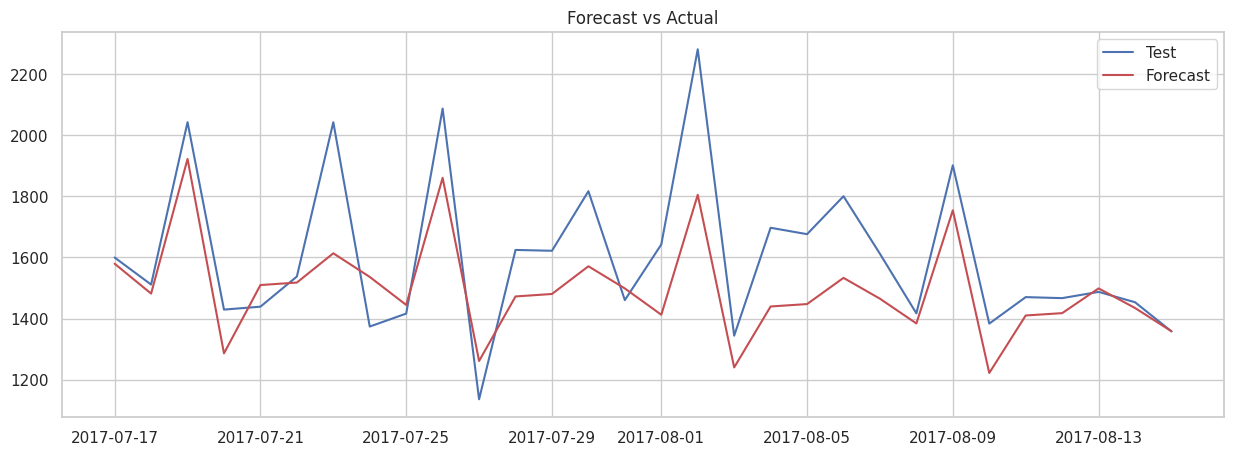

In [33]:
# Prediction
forecast = model_sarima_fit.predict(start=len(train), end=len(train)+len(test)-1, typ='levels')
forecast.index = test.index

plt.figure(figsize=(15,5))
plt.title('Forecast vs Actual')
plt.plot(test['sales'], label='Test')
plt.plot(forecast, label='Forecast', color='r')
plt.legend()

In [34]:
forecastSARIMA = pd.DataFrame({'test': test['sales'], 'forecast': forecast})
forecastSARIMA

,test,forecast
date,,
2017-07-17,1599.7670,1579.458733
2017-07-18,1511.1580,1481.609894
2017-07-19,2043.2310,1922.675194
2017-07-20,1429.2040,1285.777130
2017-07-21,1438.7240,1509.589735
2017-07-22,1537.5890,1517.759283
2017-07-23,2042.9550,1613.619454
2017-07-24,1373.6490,1536.199133
2017-07-25,1416.1060,1444.465685


# Model LSTM

In [35]:
produce

,family,sales,onpromotion,dcoilwtico,year,month,day,dayofweek,sales_mean_7,sales_mean_30
date,,,,,,,,,,
2013-01-01,PRODUCE,0.0000,0,93.14,2013,1,1,1,NaN,NaN
2013-01-02,PRODUCE,0.0000,0,93.14,2013,1,2,2,NaN,NaN
2013-01-03,PRODUCE,0.0000,0,92.97,2013,1,3,3,NaN,NaN
2013-01-04,PRODUCE,0.0000,0,93.12,2013,1,4,4,NaN,NaN
2013-01-05,PRODUCE,0.0000,0,93.12,2013,1,5,5,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2017-08-11,PRODUCE,1470.0920,6,48.81,2017,8,11,4,1608.699286,1612.735270
2017-08-12,PRODUCE,1466.7090,2,48.81,2017,8,12,5,1578.760714,1619.938637
2017-08-13,PRODUCE,1487.2210,3,48.81,2017,8,13,6,1534.003286,1618.483403


In [36]:
dcoilwtico_scaler = MinMaxScaler()
sales_scaler = MinMaxScaler()
x = produce[['onpromotion', 'dcoilwtico']].copy()
y = produce['sales'].copy()

x['dcoilwtico'] = dcoilwtico_scaler.fit_transform(x['dcoilwtico'].values.reshape(-1, 1))
y = sales_scaler.fit_transform(y.values.reshape(-1, 1))

In [37]:
def load_data(X, seq_len, test_size=30):
    amount_of_features = X.shape[1]
    X_mat = X.values
    sequence_length = seq_len + 1
    data = []

    for index in range(len(X_mat) - sequence_length):
        data.append(X_mat[index: index + sequence_length])

    data = np.array(data)
    train_data = data[:-test_size]  # Exclude last 'test_size' data points for test set

    x_train = train_data[:, :-1]
    y_train = train_data[:, -1][:,-1]

    x_test = data[-test_size:, :-1]
    y_test = data[-test_size:, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))

    return x_train, y_train, x_test, y_test

window = 7
x['sales'] = y
X_train, y_train, X_test, y_test = load_data(x, window,test_size=30)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1646, 7, 3) (1646,) (30, 7, 3) (30,)


In [38]:
modelLSTM = Sequential()
modelLSTM.add(LSTM(units=50, input_shape=(window,3)))
modelLSTM.add(Dropout(0.2))

modelLSTM.add(Dense(units=1, kernel_initializer='uniform', activation='linear'))

modelLSTM.compile(optimizer='adam',loss='mse')
start = time.time()
history1=modelLSTM.fit(X_train,y_train,epochs=100,batch_size=35, validation_split=0.05, verbose=1)
print ('compilation time : ', time.time() - start)

Epoch 1/100
45/45 [==============================] - 2s 15ms/step - loss: 0.0349 - val_loss: 0.0054
Epoch 2/100
45/45 [==============================] - 0s 4ms/step - loss: 0.0156 - val_loss: 0.0047
Epoch 3/100
45/45 [==============================] - 0s 4ms/step - loss: 0.0130 - val_loss: 0.0048
Epoch 4/100
45/45 [==============================] - 0s 5ms/step - loss: 0.0103 - val_loss: 0.0068
Epoch 5/100
45/45 [==============================] - 0s 5ms/step - loss: 0.0106 - val_loss: 0.0043
Epoch 6/100
45/45 [==============================] - 0s 4ms/step - loss: 0.0103 - val_loss: 0.0043
Epoch 7/100
45/45 [==============================] - 0s 4ms/step - loss: 0.0103 - val_loss: 0.0043
Epoch 8/100
45/45 [==============================] - 0s 4ms/step - loss: 0.0098 - val_loss: 0.0043
Epoch 9/100
45/45 [==============================] - 0s 5ms/step - loss: 0.0095 - val_loss: 0.0054
Epoch 10/100
45/45 [==============================] - 0s 5ms/step - loss: 0.0092 - val_loss: 0.0047
Epoch 11

In [39]:
trainPredict = modelLSTM.predict(X_train)
testPredict = modelLSTM.predict(X_test)

trainPredict = sales_scaler.inverse_transform(trainPredict)
trainY = sales_scaler.inverse_transform([y_train])
testPredict = sales_scaler.inverse_transform(testPredict)
testY = sales_scaler.inverse_transform([y_test])

plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(30, 1)
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(30, 1)
print(plot_actual.shape)
print(plot_predicted.shape)

1/1 [==============================] - 0s 51ms/step
(30, 1)
(30, 1)


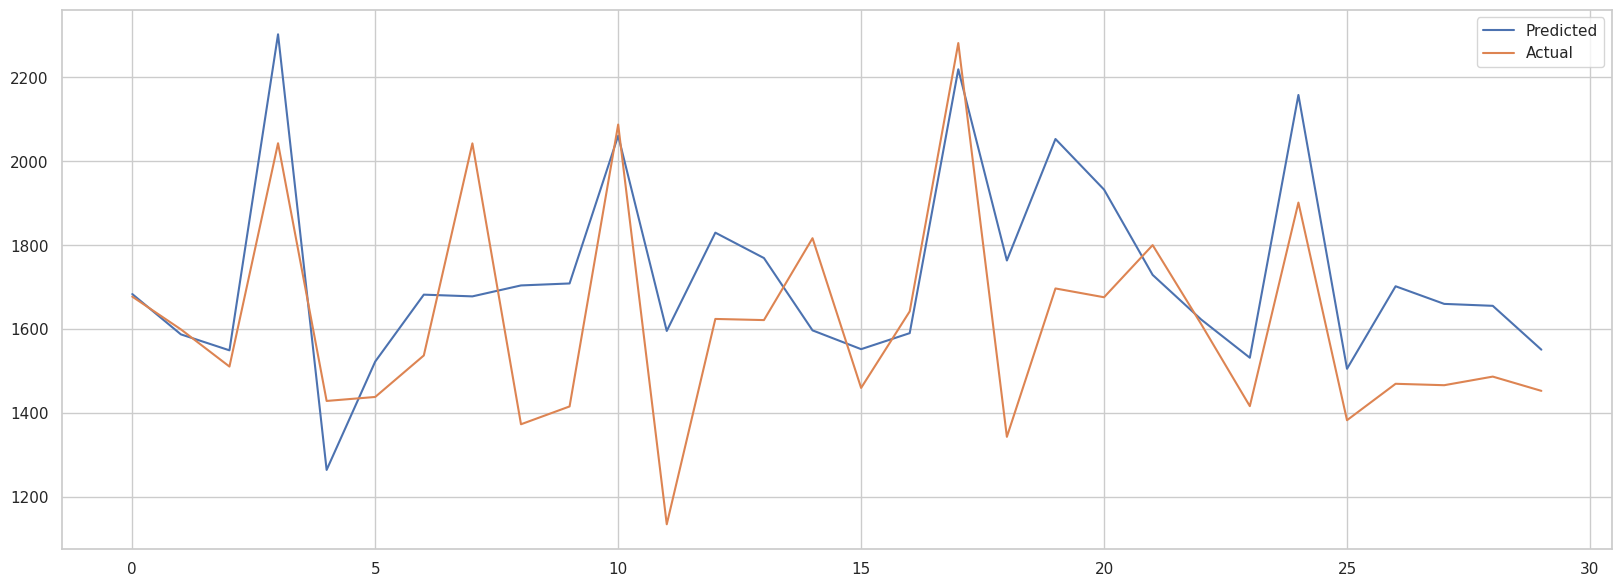

In [40]:
plt.figure(figsize=(20,7))
plt.plot(pd.DataFrame(plot_predicted), label='Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Actual')
plt.legend(loc='best')
plt.show()

In [41]:
plot_predicted = plot_predicted.reshape(30,)

forecastLSTM = pd.DataFrame({'test': test['sales'], 'forecast': plot_predicted}, index=test.index)
forecastLSTM

,test,forecast
date,,
2017-07-17,1599.7670,1683.880127
2017-07-18,1511.1580,1587.866577
2017-07-19,2043.2310,1549.806274
2017-07-20,1429.2040,2302.795654
2017-07-21,1438.7240,1264.869751
2017-07-22,1537.5890,1523.090698
2017-07-23,2042.9550,1682.478394
2017-07-24,1373.6490,1678.371704
2017-07-25,1416.1060,1704.435303


# Uji Metrik

In [42]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [43]:
model = [forecastSARIMAX, forecastSARIMA, forecastLSTM]
model_name = ['SARIMAX', 'SARIMA', 'LSTM']
metrics = []

for i in range(len(model)):
    mae = mean_absolute_error(model[i]['test'], model[i]['forecast'])
    mse = mean_squared_error(model[i]['test'], model[i]['forecast'])
    r2 = r2_score(model[i]['test'], model[i]['forecast'])
    metrics.append([mae, mse, r2])

metrics = pd.DataFrame(metrics, columns=['MAE', 'MSE', 'R2'], index=model_name)
metrics

,MAE,MSE,R2
SARIMAX,112.371056,20565.874059,0.684086
SARIMA,138.322500,32815.568732,0.495917
LSTM,297.925750,159920.274214,-1.456549
